<h1 style="color:#1A5276;padding-bottom:0px;font-size:38px;text-align:center;">Re:Invent 2019 | IoT-309</h1>
<h2 style="color:#1A5276;padding-bottom:0px;font-size:32px;text-align:center;">Combining IoT and Machine Learning for Predictive Maintenance </h2>
<p style="color:#1A5276;padding-top:0px;position:relative;font-style:italic;font-size:20px;text-align:center;">
A multivariate LSTM neural network for prediction future pollution levels to efficiently operate air filters</p>

# About

Predicting failure, remaining useful life or operating conditions is a classic request of IoT systems. By predicting which devices will fail, proactive maintenance can be scheduled to increase device uptime, optimize asset utilization, avoid costly catastrophic device failure and optimize field service efficiency. In this Notebook template, we will show how to implement a multivariate LSTM algorithm to predict pollution levels using the [Beijing PM2.5 data set](https://archive.ics.uci.edu/ml/datasets/Beijing+PM2.5+Data).

This Jupyter notebook is part of a larger solution intended to be deployed to your AWS account. Run through this notebook after air pollution data has been published into your account and stored in IoT Analytics. After finishing all steps in this notebook, you will move on to the next stage of the solution which is deploying your LSTM model to an edge solution with IoT Greengrass.

<p style="color:#1A5276;padding-top:0px;position:relative;font-style:italic;font-size:28px;text-align:center;">
Architecture diagram</p>
<img src="./architecture.png" style="float:center;">

# Set-up: import required notebook libraries

<p>This notebook requires a few basic Python libraries including <a href="http://pandas.pydata.org/">`pandas`</a>, <a href="http://www.numpy.org/">`numpy`</a>, <a href="https://keras.io/">`keras`</a>, <a href="https://www.tensorflow.org/">`tensorflow`</a>, <a href="https://scikit-learn.org/stable/">`scikit-learn`</a> and <a href="https://matplotlib.org/">`matplotlib`</a>.</p>

In [1]:
from pandas import read_csv
from datetime import datetime
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import to_datetime
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from joblib import dump, load
import numpy
import sagemaker
import pickle
import warnings
import tensorflow
from sagemaker.tensorflow import TensorFlow
import json
from sagemaker import get_execution_role
from urllib.parse import urlparse
import os
import boto3
import tarfile
from keras.models import model_from_json
from IPython.display import display, Markdown
import traceback
    
###Turn off warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
if type(tensorflow.contrib) != type(tensorflow): tensorflow.contrib._warning = None

Using TensorFlow backend.


# Background: problem description and approach

In order to support business decision making, we must be able to take action on predictive analytics. For predictive operational analysis, we want to know what would be the operating condition of equipment to optimize the parameters for increasing the life of that equipment. To solve this for real-world equipment that has multiple operation modes and reports time-series measurements from multiple sensors, our primary approach is an <a href="https://www.tensorflow.org/tutorials/recurrent">Long Short-Term Memory</a> neural network in TensorFlow. LSTM provides multivariate time series forecasting to predict the future pollution levels which could be used to automatically alter the parameters of the air filter to improve efficiency and increase remaining useful life (RUL) of air filters.

In the [CRISP-DM lifecycle](https://en.wikipedia.org/wiki/Cross-industry_standard_process_for_data_mining), we have already completed the Business Understanding phase in knowing our objective is to increase RUL of our air filtration equipment and that we are going to try using pollution forecasting to drive improvements. The next phase, which starts in this notebook, is Data Understanding. We need to evaluate the available data, look for trends, and assess whether this data will be useful to our objective.

<b style="color:#1A5276;">BEST PRACTICES NOTE</b> Different modeling approaches provide different business trade-offs, and different teams may opt for different approaches. For example, although the field service team is interested in the most precise prediction for any given filter in order to eliminate false positives and unnecessary truck rolls, a supervisor is interested in all possible devices that aren't operating at full efficiency to increase operational equipment effectiveness (OEE).

<h1 style="color:#20B3CD;font-size:30px;float:left">Step 1  |  Loading data</h1><div style="float:right;height:7px;background-color:#20B3CD;margin-top:30px;width:50%"></div>

# Data set description

The <a href="https://archive.ics.uci.edu/ml/datasets/Beijing+PM2.5+Data">Beijing PM2.5</a> is an hourly data set that contains the PM2.5 data of US Embassy in Beijing along with meteorological data from Beijing Capital International Airport. The data is collected for time period starting from Jan 1st, 2010 to Dec 31st, 2014.   

The data contain features like PM2.5 concentration (pollution level), dew point, temperature, pressure, wind direction, wind speed, cumulated hours of snow and cumulated hours of rain.

<p style="font-weight:bold">Data Set Attribution:</p> Song Xi Chen, Guanghua School of Management, Center for Statistical Science, Peking University

The data can be downloaded from this page: https://archive.ics.uci.edu/ml/datasets/Beijing+PM2.5+Data

The data has been split into training, validation and test data sets. The first 2 years of data is used for training data, followed by the next 2 year of data as validation to check the training accuracy. The last 1 year of data will later be used for device simulation testing.

To load data already ingested from your device to the cloud, we need to set up an IoT Analytics SDK client to access your data set. This code initializes the client, fetches content from your data set, sorts by time, and previews the first five rows.

In [3]:
s3Bucket = "XYZ-S3Bucket-XYZ"
dataset = "XYZ-IotAnalyticsDataset-XYZ"
use_local_data = True

if use_local_data:
    dataset_url = "source_pollution.csv"
else:
    iotanalytics_client = boto3.client('iotanalytics')
    dataset_url = iotanalytics_client.get_dataset_content(datasetName = dataset)['entries'][0]['dataURI']

dataset = read_csv(dataset_url, header=0, index_col='date')
if dataset.empty:
    raise Exception('No data found')
dataset.sort_index(inplace=True)
dataset = dataset[['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']]
dataset.drop_duplicates(inplace=True)
dataset.to_csv('pollution.csv')

# displays the first few entries of the DataFrame
dataset.head() 

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,2,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,2,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,2,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,2,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,2,6.25,2,0


Start a new session in SageMaker and make the training data available in S3.

In [4]:
###Upload this queried data to s3
sagemaker_session = sagemaker.Session()
uploaded_data_path = sagemaker_session.upload_data(path='pollution.csv', bucket=s3Bucket, key_prefix='data')

Plot the columns to understand statistical properties of the data set.

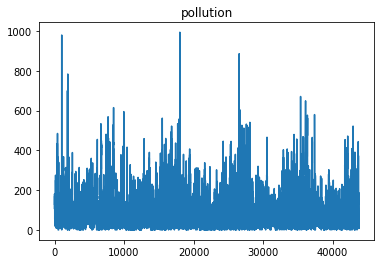

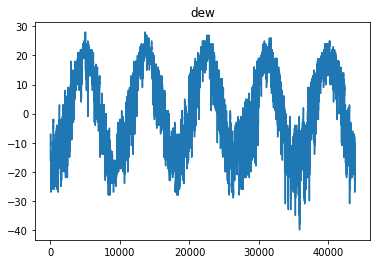

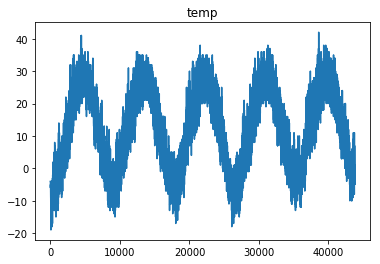

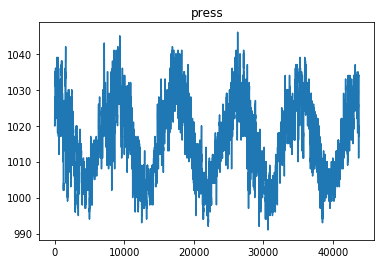

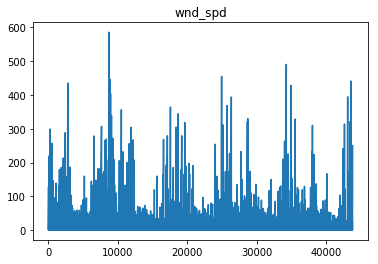

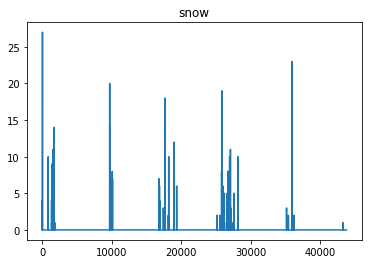

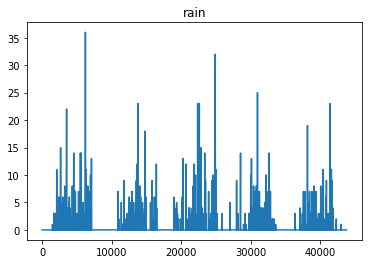

In [5]:
values = dataset.values
# specify columns to plot
columns_to_plot = [0, 1, 2, 3, 5, 6, 7]
for column_index in columns_to_plot:
	pyplot.figure()
	pyplot.subplot(1, 1, 1)
	pyplot.plot(values[:, column_index])
	pyplot.title(dataset.columns[column_index])
    

We can visually observe some seasonal values in dew, temp, pressure and snow attributes in the above plots. However, we don't observe any particular statistical features in the pollution readings. We need to further analyze the features of our pollution readings.  

We are using a library <a href="https://www.statsmodels.org/stable/index.html/">`statsmodels`</a> to see if there is any seasonality in the pollution readings. Seasonality or periodicity in data is often useful in picking the suitable ML algorithm.

Let's first observe the first month of pollution data. 

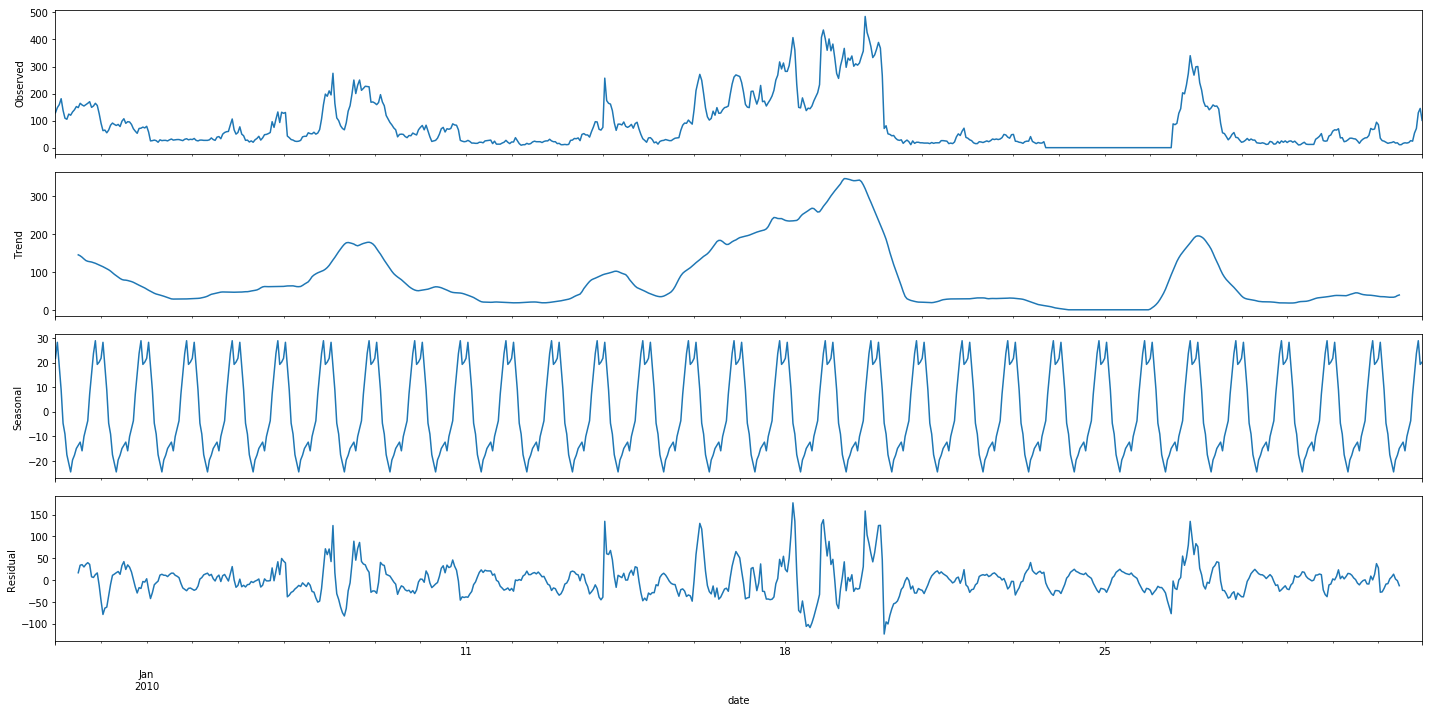

In [6]:
###Exploring short term seasonality in data
import statsmodels.api as sm
trend_dataset = dataset.reset_index()
trend_dataset = trend_dataset[['date', 'pollution']]
trend_dataset['date'] = to_datetime(trend_dataset['date'])
trend_dataset = trend_dataset.set_index('date')

pyplot.rcParams["figure.figsize"] = (20,10)
number_of_monthly_datapoints = 24*30
decomposition = sm.tsa.seasonal_decompose(trend_dataset[:number_of_monthly_datapoints], model='additive')
fig = decomposition.plot()

If we observe the seasonal plot above, we can find that our pollution dataset has a daily seasonality in it.     

Let's try to look for long term seasonality by forcing the model to ignore short term seasonality we found above. By setting the `freq` to a larger number. We are setting it here to look for monthly seasonality in the first year of pollution data. 

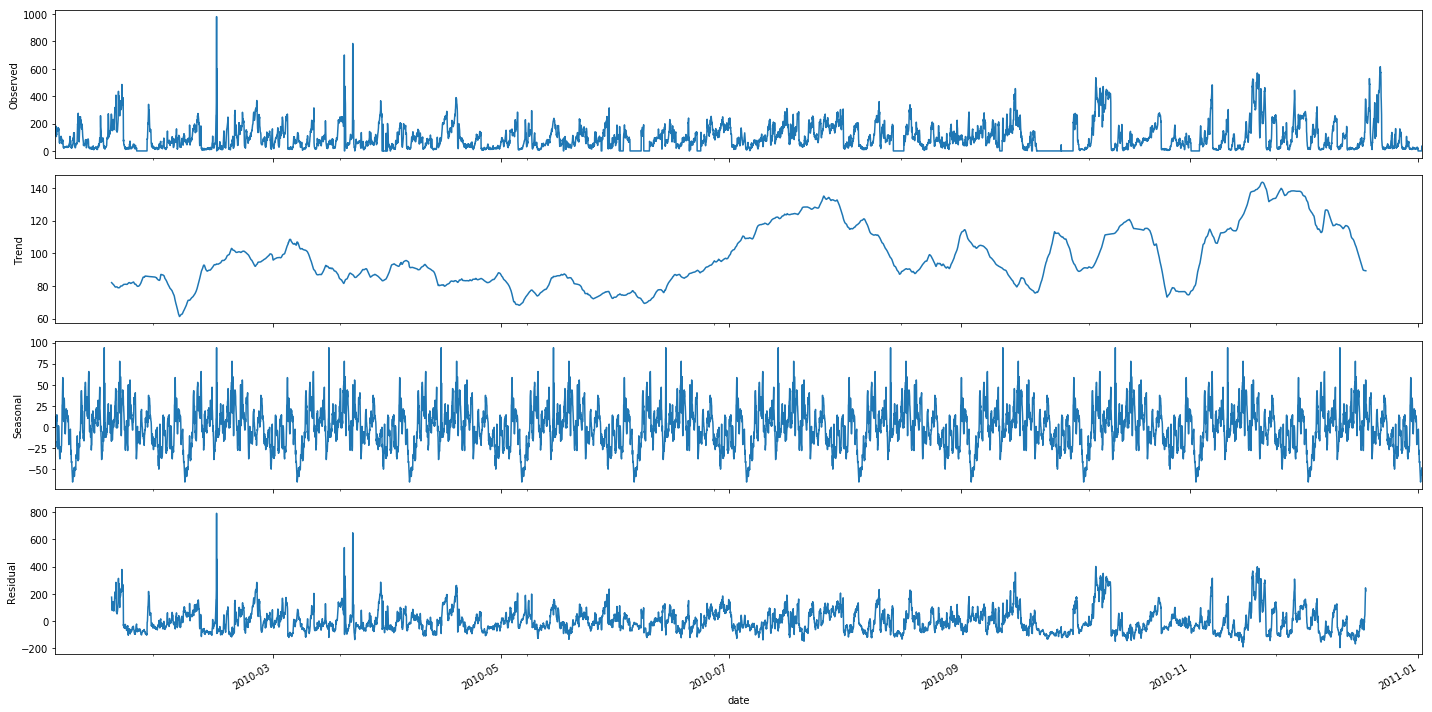

In [7]:
###Exploring long seasonality in data
number_of_yearly_datapoints = 24*365
decomposition = sm.tsa.seasonal_decompose(trend_dataset[:number_of_yearly_datapoints], model='additive', freq=number_of_monthly_datapoints)
fig = decomposition.plot()

If we observe the seasonal plot above, we can find that our pollution dataset also has a monthly seasonality in it (observe the 12 similar segments in the 1 year of data).

We can observe that pollution data has both long (monthly) and short (daily) term periodicity. 

<h1 style="color:#20B3CD;font-size:30px;float:left">Step 2  |  Processing data</h1> <div style="float:right;height:7px;background-color:#20B3CD;margin-top:30px;width:50%"></div>

# Sensor measurement normalization

The next step of the CRISP-DM lifecycle is Data Preparation. These next steps are about manipulating the desired data into a format best fit for machine learning.

Multivariate problems require normalization of sensor measurements and operational settings to remove the effects of different scales being used across the units of measure. For example, wind speed versus cumulated hours of snow/rain operate in different orders of magnitude. The 'MinMaxScaler' transforms each value into a given range, in our case between 0 and 1.

Below is the transformation we are performing on each sensor measurement. [Learn more](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) about preprocessing with **sklearn**.

\begin{align}
X_{std} & = (X - X_{min})/(X_{max} - X_{min}) \\
X_{scaled} & = X_{std} * (feature\_range_{max} - feature\_range_{min}) + feature\_range_{min}
\end{align}

In [8]:
#Transform all columns as float
values = values.astype('float32')

#Normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
normalized_values = scaler.fit_transform(values)

# Target parameter determination

In order to model a LSTM, we need a target parameter that puts all the data on the same basis for supervised training and the subsequent classification test. For time-series forecasting of pollution levels, we will assume attribute data from the previous timestamp being associated with pollution levels of the current timestamp.  

To mark these observations into supervised learning, we first need to transform the data set where the all previous timestamp's attributes (including the pollution level) are the variables and current pollution level is the target value.

<b style="color:#1A5276;">BEST PRACTICES NOTE</b> In this example, only the last timestamp's attributes are used for training and prediction. A deeper lookback into the history may increase model accuracy while increasing the complexity and training time.  

In [10]:
#Convert series to supervised learning
def transform_to_supervised_series(data, columns, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('%s(t-%d)' % (columns[j], i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('%s(t)' % (columns[j])) for j in range(n_vars)]
		else:
			names += [('%s(t+%d)' % (columns[j], i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

#Frame as supervised learning
supervised_series_dataset = transform_to_supervised_series(normalized_values, dataset.columns, 1, 1)
#Drop the unnecessary columns
supervised_series_dataset.drop(['dew(t)', 'temp(t)', 'press(t)', 'wnd_dir(t)', 'wnd_spd(t)', 'snow(t)', 'rain(t)'], axis=1, inplace=True)

The data has been prepared for supervised learning as described in the previous cell. Let's take a look at the first five rows.

In [11]:
supervised_series_dataset.head()

,pollution(t-1),dew(t-1),temp(t-1),press(t-1),wnd_dir(t-1),wnd_spd(t-1),snow(t-1),rain(t-1),pollution(t)
1,0.129779,0.352941,0.245902,0.527273,0.666667,0.002290,0.000000,0.0,0.148893
2,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0,0.159960
3,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0,0.182093
4,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0,0.138833
5,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0,0.109658


# Split the data into training, validation and test data sets

We will now split the data into training, validation and test data sets. The first 2 years of data is used for training data, followed by the next 2 years of data as validation to check the training accuracy. The last 1 year of data has been used for device simulation testing.

In [12]:
######Splitting data into training and test data
values = supervised_series_dataset.values
n_train_hours = 24*365*2
n_validation_hours = 24*365*4 
train = values[:n_train_hours, :]
validation = values[n_train_hours:n_validation_hours, :]

# Split the training and validation data sets into input and output data sets

LSTM model takes input in a 3D format where the 1st axis are the samples, 2nd axis is the timesteps that you want to take and the last axis is the features. We would need to transform out input data into this format. 

In [13]:
#Split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
validation_X, validation_y = validation[:, :-1], validation[:, -1]
#Reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
validation_X = validation_X.reshape((validation_X.shape[0], 1, validation_X.shape[1]))

<h1 style="color:#20B3CD;font-size:30px;float:left">Step 3  |  Train and test model</h1> <div style="float:right;height:7px;background-color:#20B3CD;margin-top:30px;width:50%"></div>

# Time-series forecasting via LSTM

LSTM or 'Long Short-Term Memory' is a recurrent neural network that is particularly forgiving of unknown time gaps between significant events in time-series data, such as the unknown periodicity in the pollution levels. LSTM is capable of handling large data sets. This makes it very useful for prediction with time-series IoT data. 

Keras LSTM layers expect an input in the following shape: (batch_size, timesteps, input_dim)
<div><b style="margin-left:50px;font-style:italic;font-size:13px;">batch_size</b> - number of sequences</div>
<div><b style="margin-left:50px;font-style:italic;font-size:13px;">timesteps</b> - the sequence length to look back, look back cycles in our example</div>
<div><b style="margin-left:50px;font-style:italic;font-size:13px;">input_dim</b> - number of features of each sequence at each time step</div>

</img><b style="color:#1A5276">HUMAN LEARNING NOTE</b> Keras is a neural network (NN) framework that makes running NN fast and easy on TensorFlow. Alternatives to Keras include Theano and CNTK.

# LSTM model setup
Now that we have the data structured for training we can set the parameters in our LSTM model. Here we are using a sequential LSTM model for time-series forecasting. This model configuration choice makes our model capable of learning higher-level temporal representations. We could see in the earlier data visualization that our data has long-term temporal periodicity.

`Epoch` is a hyperparameter in ML model to control the number of complete passes through the training dataset. Larger epoch number usually allows the learning algorithm to run until the error from the model has been sufficiently minimized. 

`Batch Size` is another hyperparameter in ML model that defines the number of samples to work through before updating the internal model parameters.

`Mean Absolute Error (MAE)` is one of the most commonly used regression loss function. MAE is the sum of absolute differences between our target and predicted variables. So, it measures the average magnitude of errors in a set of predictions, without considering their directions. The range is also 0 to ∞


`Adam optimizer` is an adaptive learning rate optimization algorithm that’s been designed specifically for training deep neural networks. The algorithms leverage the power of adaptive learning rates methods to find individual learning rates for each parameter. It also has advantages of Adagrad, which works really well in settings with sparse gradients, but struggles in non-convex optimization of neural networks, and RMSprop, which tackles to resolve some of the problems of Adagrad and works really well in on-line settings. Its name is derived from adaptive moment estimation and uses estimations of first and second moments of gradient to adapt the learning rate for each weight of the neural network. 

<b style="color:#1A5276">HUMAN LEARNING NOTE</b> You can read about different supported optimizers and losses on Keras <a href="https://keras.io/optimizers/">`optimizers`</a> and <a href="https://keras.io/losses/">`losses`</a>.

In [15]:
#LSTM for time-series predictions
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 50)                11800     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 11,851
Trainable params: 11,851
Non-trainable params: 0
_________________________________________________________________
None


We are using an LSTM with 50 neurons in the first hidden layer and 1 neuron in the output layer for predicting pollution. The input shape will be 1 time step with 8 features. We reached to this model after tuning these parameters based on some experimentation, you can try to play around with these to see if you can tune them better. 

# Model training

The next step of the CRISP-DM lifecycle is Modeling, where we start the process of training and testing models.

Since LSTM is a recurrent neural network we can observe the incremental training at each iteration or epoch on the training data set. 

`loss` is the value of cost function on our training data.
`val_loss` is the value of cost function for your cross-validation data.

These values are useful in determining if our model is overfitting to training data. If we have `loss` noticeably lower than `val_loss` then it is the sign of overfitting.

<b style="color:#1A5276;">PRODUCTION NOTE</b> we have chosen to train over 50 epochs. This allows us to test the model within a reasonable timeframe (~15 mins). 

In [ ]:
### fit network
#history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(validation_X, validation_y), verbose=2, shuffle=False)
#history = history.history

###Instead of training here, we are calling it through a training job, since sagemaker will pack the model for us and 
###upload it on to s3 to make it easier for us use

###We are performing a m5.xlarge instance for training , you can do local training if you want to. 
###You can change the train_instance_type to a different p type sagemaker instance for faster training.
###Note: Local training doesn't result into a training job that can be used for green grass directly
use_local_training = False 

if use_local_training:
    train_instance_type = "local"
else: 
    train_instance_type = "ml.m5.xlarge"
    
tf_estimator = TensorFlow(entry_point='trainLSTM.py', role=get_execution_role(),
                          train_instance_count=1, train_instance_type=train_instance_type,
                          framework_version='1.12', py_version='py3', script_mode=True,
                          output_path = 's3://' + s3Bucket, base_job_name = "pollution-forecasting-lstm",
                          hyperparameters={'batch_size': 72,
                                           'epochs': 50,
                                           'n_train_hours': n_train_hours,
                                           'n_validation_hours': n_validation_hours})

tf_estimator.fit(uploaded_data_path)

2019-11-26 19:49:34 Starting - Starting the training job...
2019-11-26 19:49:35 Starting - Launching requested ML instances......
2019-11-26 19:50:57 Starting - Preparing the instances for training......
2019-11-26 19:51:58 Downloading - Downloading input data
2019-11-26 19:51:58 Training - Downloading the training image..2019-11-26 19:52:12,958 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
2019-11-26 19:52:12,963 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2019-11-26 19:52:13,229 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2019-11-26 19:52:13,243 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2019-11-26 19:52:13,253 sagemaker-containers INFO     Invoking user script

Training Env:

{
    "additional_framework_parameters": {},
    "channel_input_dirs": {
        "training": "/opt/ml/input/data/training"
    },
    "current_host": "algo-1",
    "fram

#### Download the training model and history created using training job
This next code downloads the training model that we have created the through the SageMaker training job. 
It copies the trained model in tar.gz-format from S3 to this notebook instance and unpacks it. The model files will be stored in the local file directory **[job\_name]/model**. [job\_name] is a placeholder that is different every time you run this notebook. When copying and unpacking are finished the names of your model files will be printed below the cell.

In [ ]:
print("job_name: {}".format(tf_estimator.latest_training_job.name))

s3_model_path = '{}'.format(tf_estimator.model_data)
print("s3_model_path: {}".format(s3_model_path))
s3_bucket = urlparse(s3_model_path).netloc
print(s3_bucket)
s3_key = urlparse(s3_model_path).path.lstrip('/')
print("s3_key: {}".format(s3_key))

local_model_dir = 'model'
if not os.path.exists(local_model_dir):
    try:
        os.makedirs(local_model_dir)
    except Exception as e:
        print("ERROR: failed to created directory {}: {}".format(local_model_dir, e))

if not os.path.exists(local_model_dir + '/model.tar.gz'):
    s3_client = boto3.client('s3')
    s3_client.download_file(s3_bucket, s3_key, local_model_dir + '/model.tar.gz')
    
tar = tarfile.open(local_model_dir + '/model.tar.gz')
tar.extractall(path=local_model_dir)
tar.close()

model_files = os.listdir(local_model_dir)
print("model_files: {}".format(model_files))

### Read the model file and history
The model files that we have downloaded above need to be loaded here in the notebook.

In [15]:
scaler = load('%s/scaler.model' % local_model_dir)

with open('%s/model.json' % local_model_dir, 'r') as json_file:
    loaded_model_json = json_file.read()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights('%s/model.h5' % local_model_dir)

with open('%s/history.json' % local_model_dir) as f:
    history = json.load(f)
loaded_model.compile(loss='mae', optimizer='adam')

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.21.1 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


#### Model accuracy and overfit check
The next step in CRISP-DM is Evaluation. Now that we've trained a model, we must inspect its performance in forecasting pollution of time N against the actual time N. Let's compare the `loss` and `val_loss` of the model to see if we ended overfitting or not.


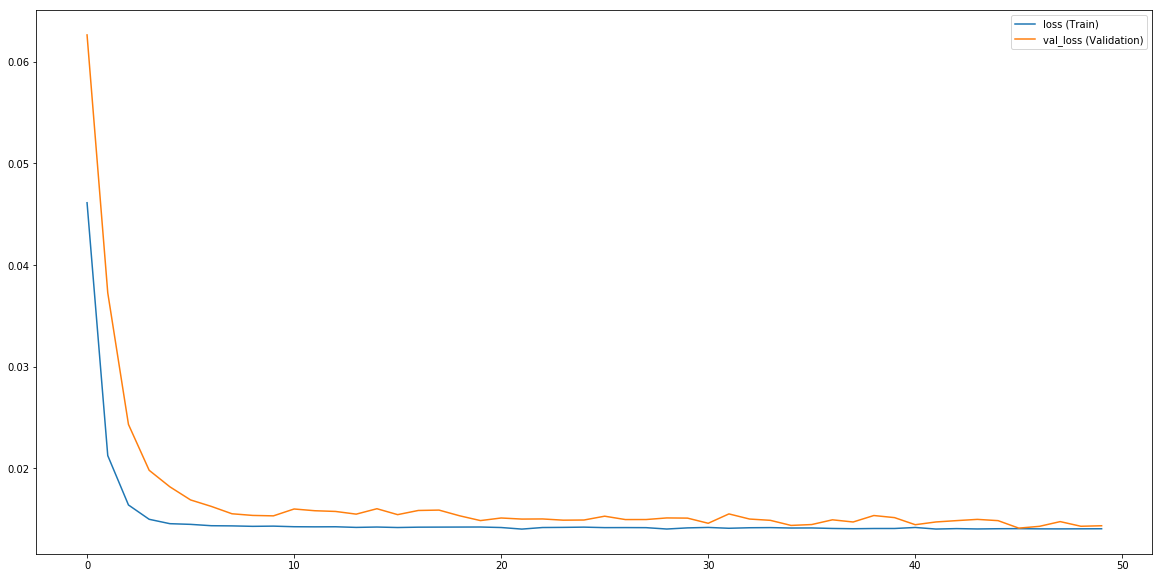

In [16]:
# plot accuracy as we learn
pyplot.plot(history['loss'], label='loss (Train)')
pyplot.plot(history['val_loss'], label='val_loss (Validation)')
pyplot.legend()
pyplot.show()

As you may have noticed, the loss of the train dataset is similar to the val_loss of the validation data. This corresponds that we have not overfitted out model onto training data.

<h1 style="color:#20B3CD;font-size:20px;float:left">Step 4  |  Results summary</h1> <div style="float:right;height:7px;background-color:#20B3CD;margin-top:30px;width:50%"></div>

### Apply model to test data

Let's make inferences from the trained model onto our validation dataset

In [17]:
yhat = loaded_model.predict(validation_X)
#If trained within the notebook use yhat = model.predict(validation_X)

### Calculate the root mean square error 
We can calculate the root mean square error (RMSE) on the validation data set to evaluate the performance of our model. Unlike classification problems, in regressions problems like this one it is hard to calculate the accuracy of a model, so we use RMSE to benchmark the model's performance.

In [18]:
validation_X = validation_X.reshape((validation_X.shape[0], validation_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, validation_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
validation_y = validation_y.reshape((len(validation_y), 1))
inv_y = concatenate((validation_y, validation_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

print("\n\nLSTM Metrics")
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Val RMSE: %.3f' % rmse)



LSTM Metrics
Val RMSE: 27.931


In this case, our RMSE is approximately 30 (your exact number may vary by a few percent).

### Benchmarking with a Persistence Model
The persistence forecast is where the observation from the prior time step (t-1) is used to predict the observation at the current time step (t).

In [19]:
#Let's create a naive persistence model to benchmark the performance of our model

##Creating a dateframe with the previous timestep values and using that as prediction for next step
persistence_model_df = DataFrame()
persistence_model_df['pollution(t-1)'] = dataset['pollution']
persistence_model_df['predicted_pollution(t)'] = persistence_model_df['pollution(t-1)']
persistence_model_df.head(5)

,pollution(t-1),predicted_pollution(t)
date,,
2010-01-02 00:00:00,129.0,129.0
2010-01-02 01:00:00,148.0,148.0
2010-01-02 02:00:00,159.0,159.0
2010-01-02 03:00:00,181.0,181.0
2010-01-02 04:00:00,138.0,138.0


### Calculate the root mean square error for persistence model for validation data

In [20]:
#Let's extract the actual values
persistence_model_y = persistence_model_df[['pollution(t-1)']].values[1:].astype('float32')
#Extract the predicted values
persistence_model_y_hat = persistence_model_df[['predicted_pollution(t)']].values[:-1].astype('float32')

#Filter out for validation dataset only
persistence_model_y = persistence_model_y[n_train_hours:n_validation_hours, :]
persistence_model_y_hat = persistence_model_y_hat[n_train_hours:n_validation_hours, :]

persistence_model_y = persistence_model_y.reshape((len(persistence_model_y)))
persistence_model_y_hat = persistence_model_y_hat.reshape((len(persistence_model_y_hat)))
persistence_model_rmse = sqrt(mean_squared_error(persistence_model_y, persistence_model_y_hat))
print('Val RMSE for Persistence Model: %.3f' % persistence_model_rmse)

Val RMSE for Persistence Model: 27.436


In this case, our vanilla LSTM model is performing similar to a persistence model. We can experiment with hyperparameter tuning to further enhance the model and reduce its error.

<h1 style="color:#20B3CD;font-size:20px;float:left">Summary</h1> <div style="float:right;height:7px;background-color:#20B3CD;margin-top:30px;width:50%"></div>

At this stage you have successfully trained and tested a LSTM model to forecast air pollution! The next stage of the CRISP-DM lifecycle is Deployment. That happens outside the scope of this notebook. Resume the next step of this solution from the associated README file.

The code in this notebook is not tightly correlated to the air pollution data set. You could continue experimenting beyond the scope of this solution by bringing an alternate data set, changing the window of the Beijing 2.5PM used to train, or experimenting with the LSTM hyperparameters to see the effect they have on model accuracy (RMSE).